In [1]:

%pip install transformers datasets evaluate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 48.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 100.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 13.6 MB/s eta 0:00:00


In [2]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
from evaluate import load

perplexity = load("perplexity", module_type="metric")

In [4]:
from datasets import load_dataset

ds = load_dataset('martingrzzler/mnemonics_benchmark')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/martingrzzler___json/martingrzzler--mnemonics_benchmark-6cc75b71b93e3c15/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
import re
def clean(text):
    return re.sub('<.*?>', '', text)

In [43]:
keys = ['gpt2xl_mnemonic', 'gpt3_mnemonic', 'gpt3_paragraph', 'wanikani_mnemonic']

def map_ppl(example):
    predictions = []
    for key in keys:
        predictions.append(clean(example[key]))
    
    res = perplexity.compute(predictions=predictions, model_id='gpt2', device=device)
    for i, key in enumerate(keys):
        example[key + '_ppl'] = res['perplexities'][i]

    return example

In [ ]:
ds_ppl = ds.map(map_ppl)

In [16]:
ds_ppl

DatasetDict({
    train: Dataset({
        features: ['kanji_id', 'component_meanings', 'wanikani_mnemonic', 'kanji_meaning', 'gpt2xl_mnemonic', 'gpt3_paragraph', 'gpt3_mnemonic', 'gpt2xl_mnemonic_ppl', 'gpt3_mnemonic_ppl', 'gpt3_paragraph_ppl', 'wanikani_mnemonic_ppl'],
        num_rows: 190
    })
})

In [19]:
from scipy.stats import f_oneway

f, p = f_oneway(*[ds_ppl['train'][key + '_ppl'] for key in keys])
print(f, p)

92.09518449753575 8.353443167316626e-51


In [20]:
from scipy.stats import tukey_hsd

res = tukey_hsd(*[ds_ppl['train'][key + '_ppl'] for key in keys])
print(res)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      7.003     0.000     3.340    10.665
 (0 - 2)     -2.553     0.277    -6.216     1.109
 (0 - 3)    -16.051     0.000   -19.713   -12.388
 (1 - 0)     -7.003     0.000   -10.665    -3.340
 (1 - 2)     -9.556     0.000   -13.219    -5.894
 (1 - 3)    -23.053     0.000   -26.716   -19.391
 (2 - 0)      2.553     0.277    -1.109     6.216
 (2 - 1)      9.556     0.000     5.894    13.219
 (2 - 3)    -13.497     0.000   -17.160    -9.835
 (3 - 0)     16.051     0.000    12.388    19.713
 (3 - 1)     23.053     0.000    19.391    26.716
 (3 - 2)     13.497     0.000     9.835    17.160



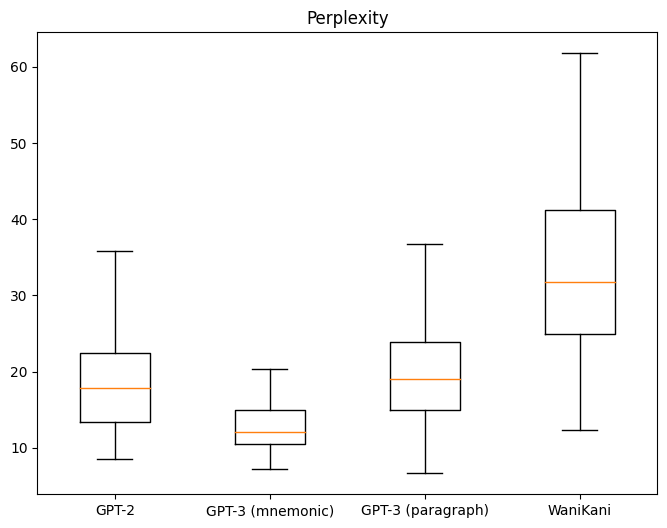

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.boxplot([ds_ppl['train'][key + '_ppl'] for key in keys], labels=['GPT-2','GPT-3 (mnemonic)','GPT-3 (paragraph)','WaniKani'], showfliers=False)
plt.title('Perplexity')
plt.show()

In [26]:
# mean and std

for key in keys:
    print(key, f"{ds_ppl['train'].to_pandas()[key + '_ppl'].mean():.2f}, {ds_ppl['train'].to_pandas()[key + '_ppl'].std():.2f}")

gpt2xl_mnemonic 20.08, 12.71
gpt3_mnemonic 13.08, 4.30
gpt3_paragraph 22.63, 16.18
wanikani_mnemonic 36.13, 18.08


In [7]:
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [49]:
from nltk import word_tokenize 
import re

def tokenize(text, n=4):
    text = re.sub('<.*?>', '', text)
    words = text.split(' ')
    for i in range(0, len(words), n):
        yield ' '.join(words[i:i+n])


In [50]:
import random

for key in keys:
    print(key)
    text = random.choice(ds['train'][key])
    print(text)
    print(list(tokenize(text)))
    print()

gpt2xl_mnemonic
It's been a long time coming, but it looks like blade runner Harrison Ford will finally make his return to the big screen in Star Wars: Episode VII – The Force Awakens. And he'll be joined by an all-star cast that includes Oscar winner Lupita Nyong'o (12 Years A Slave), Domhnall Gleeson blade
["It's been a long", 'time coming, but it', 'looks like blade runner', 'Harrison Ford will finally', 'make his return to', 'the big screen in', 'Star Wars: Episode VII', '– The Force Awakens.', "And he'll be joined", 'by an all-star cast', 'that includes Oscar winner', "Lupita Nyong'o (12 Years", 'A Slave), Domhnall Gleeson', 'blade']

gpt3_mnemonic
Once upon a time there was a stupid man who had a sickness. He was so sick that he decided to shoot an arrow out of his mouth. He didn't realize how stupid this was and the arrow ended up getting stuck in his throat. Fortunately, he was able to get medical attention and the arrow was removed. But he learned his lesson and never tried to

In [60]:
def map_ngram_ppl(example):
    for key in keys:
        example[key + '_ppl'] = perplexity.compute(predictions=list(tokenize(example[key])), model_id='gpt2', device=device)['mean_perplexity']
    
    return example

In [ ]:
ds_ngram_ppl = ds['train'].map(map_ngram_ppl)

In [62]:
from scipy.stats import f_oneway

f, p = f_oneway(*[ds_ngram_ppl[key + '_ppl'] for key in keys])
print(f, p)

18.089238213159256 2.4099793321472688e-11


In [63]:
from scipy.stats import tukey_hsd

res = tukey_hsd(*[ds_ngram_ppl[key + '_ppl'] for key in keys])
print(res)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)   2030.703     0.000  1178.320  2883.085
 (0 - 2)   2105.457     0.000  1253.075  2957.840
 (0 - 3)   1778.193     0.000   925.811  2630.576
 (1 - 0)  -2030.703     0.000 -2883.085 -1178.320
 (1 - 2)     74.754     0.996  -777.628   927.137
 (1 - 3)   -252.509     0.871 -1104.892   599.873
 (2 - 0)  -2105.457     0.000 -2957.840 -1253.075
 (2 - 1)    -74.754     0.996  -927.137   777.628
 (2 - 3)   -327.264     0.756 -1179.646   525.119
 (3 - 0)  -1778.193     0.000 -2630.576  -925.811
 (3 - 1)    252.509     0.871  -599.873  1104.892
 (3 - 2)    327.264     0.756  -525.119  1179.646



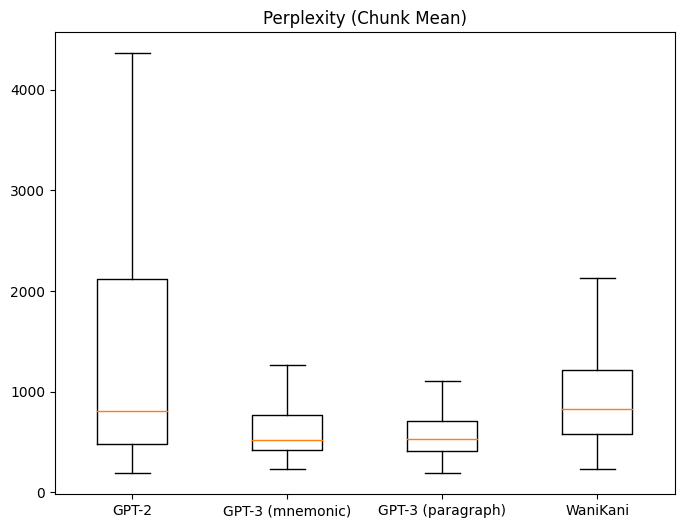

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.boxplot([ds_ngram_ppl[key + '_ppl'] for key in keys], labels=['GPT-2','GPT-3 (mnemonic)','GPT-3 (paragraph)','WaniKani'], showfliers=False)
plt.title('Perplexity (Chunk Mean)')
plt.show()

In [67]:
# mean and std

for key in keys:
    print(key, f"{ds_ngram_ppl.to_pandas()[key + '_ppl'].mean():.2f}, {ds_ngram_ppl.to_pandas()[key + '_ppl'].std():.2f}")

gpt2xl_mnemonic 2734.07, 6373.10
gpt3_mnemonic 703.37, 741.24
gpt3_paragraph 628.61, 361.23
wanikani_mnemonic 955.87, 591.97
